## Section 1 Preprocessing  

In [2]:
# you should be able to import these packages
import numpy as np
from PIL import Image
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from munkres import Munkres

In [3]:
# Now let's load the detection and embedding file
detection = np.loadtxt('detection.txt',delimiter=',',dtype=None)
embedding = np.load('embedding.npy', allow_pickle=True)

# Each detection has a corresponding embedding feature, so the length should be the same!
assert len(detection) == len(embedding)
print('total number of detections : {}'.format(len(detection)))

total number of detections : 307857


In [4]:
# Create empty dictionaries to store sorted detection and embedding data

#The detection file contains information about detected objects or features in each frame.
detections = {}

# The embedding file contains the feature vectors for each detected object or feature.
embeddings = {}

# Iterate over the frame numbers 71 to 75
for data in range(71, 76):
    # Create a boolean mask to filter rows where the frame number matches the current data value
    inds = detection[:, 0] == data
    
    # Apply the mask to the detection and embedding arrays
    temp_detect = detection[inds]
    temp_embed = embedding[inds]
    
    # Sort the temp_detect array based on the values in the second column
    sort_inds = temp_detect[:, 1].argsort()
    
    # Assign the sorted arrays to the detections and embeddings dictionaries
    detections[data] = temp_detect[sort_inds]
    embeddings[data] = temp_embed[sort_inds]


In [5]:
# Create an empty dictionary to store frame-level information for each video
frame_info = {}

# Iterate over the video IDs from 71 to 75
for vid in range(71, 76):
    # Create an empty dictionary to store frame-level information for the current video
    vid_frames = {}
    
    # Retrieve the detections and embeddings for the current video
    dets = detections[vid]
    embs = embeddings[vid]
    
    # Get the unique frame numbers present in the detections array
    unique_frames = np.unique(dets[:, 1])
    
    # Iterate over the unique frame numbers
    for frame in unique_frames:
        # Create a boolean mask to filter rows where the frame number matches the current frame
        inds = dets[:, 1] == frame
        
        # Filter the detections and embeddings based on the current frame
        frame_dets = dets[inds]
        frame_embs = embs[inds]
        
        # Store the list of tuples containing the detections and embeddings for the current frame
        vid_frames[frame] = list(zip(frame_dets, frame_embs))
    
    # Assign the vid_frames dictionary to the frame_info dictionary using the video ID as the key
    frame_info[vid] = vid_frames


## Section 2 Helper Functions

In [6]:
class Object_Detection(tuple):
    def __new__(cls, detection, trackID=-1):
        """
        Detection input format:
        (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)
        
        Output detection object format:
        (<camera ID>, <tracking ID>, <Frame ID>, <x1>, <y1>, <w>, <h>, -1, -1)
        """
        assert len(detection) == 8 # 'Detection tuple should have 8 elements!'
        output = list(detection)
        output[2] = output[1]
        output[1] = trackID
        output[-1] = -1
        output.append(-1)
        transformed_detection = tuple(output)
        return super().__new__(cls, transformed_detection)


In [7]:
# The detection file contains the detection from the five cameras. Let's take out the detection from the camera 74, which is our validation set.

inds = detection[:,0] == 75
val_detection = detection[inds]
val_embedding = embedding[inds]

assert len(val_detection) == len(val_embedding)
print('total number of detections in the validation set : {}'.format(len(val_detection)))

total number of detections in the validation set : 80816


In [8]:
# Sort the detection and embedding with frame ID
# Make sure to use argument sort!!! Otherwise the order between detection and embedding will not match!!

sort_inds = val_detection[:, 1].argsort()
val_detection = val_detection[sort_inds]
val_embedding = val_embedding[sort_inds]

# Now let's check the format of detection file.
# The format is <camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>
# x1:left y1:upper x2:right y2:lower
# In the following example, we have camera ID = 74, Frame ID = 1, class = 1 (we only have 1 class which is human), x1 = 1625, y1 = 352, x2 = 1748, y2 = 708, and confidence score = 0.93

print([x for x in val_detection[0]])

[75.0, 0.0, 1.0, 1147.0, 422.0, 1209.0, 682.0, 0.8]


In [9]:
#NEW
# Show an image from a specified camera and detection number
def plot_det_img(video_num, detection_num):
    camera,frame,_,x1,y1,x2,y2,_ = detections[video_num][detection_num]
    image = Image.open('c0{}/img/{}.jpg'.format(video_num, '%05d'%frame)).crop((x1,y1,x2,y2))
    return image

# Show an image from the detection data
def plot_img_det(det):
    return Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[1])).crop((det[3], det[4], det[5], det[6]))

In [10]:
def distance_between(v1, d1, v2, d2):
    # Calculate the cosine distance between the embeddings of the two detections
    cos_dist = distance.cosine(embeddings[v1][d1], embeddings[v2][d2])

    # Print the cosine distance
    print("Cosine distance between two detections:", cos_dist)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image for the first detection in the first subplot
    axs[0].imshow(plot_det_img(v1, d1))
    axs[0].axis('off')
    axs[0].set_title(f'Detection {d1} (Video {v1})')

    # Display the image for the second detection in the second subplot
    axs[1].imshow(plot_det_img(v2, d2))
    axs[1].axis('off')
    axs[1].set_title(f'Detection {d2} (Video {v2})')

    # Set a title for the figure
    fig.suptitle('Detections Comparison')

    # Adjust the spacing between subplots
    plt.tight_layout()

Cosine distance between two detections: 0.0010015368461608887


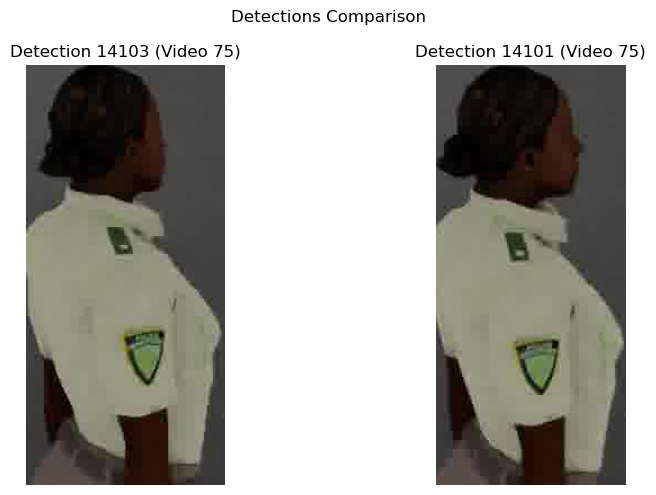

In [34]:
# See the cosine distance between two detections is large and people are different
distance_between(75, 14103, 75, 14101)

Cosine distance between two detections: 0.765363335609436


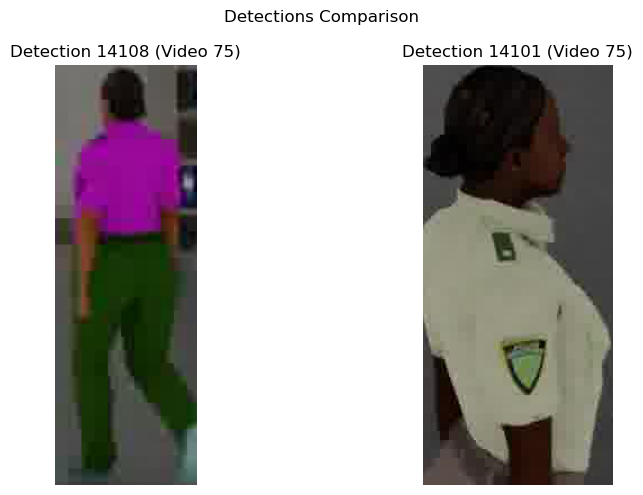

In [36]:
distance_between(75, 14108, 75, 14101)

In [12]:
# Get the detection data of all detections in a specified frame
def video_frame_data(vid_num, frame_num):
    dets = detections[vid_num]
    embs = embeddings[vid_num]
    inds = dets[:, 1] == frame_num
    frame_dets = dets[inds]
    frame_embs = embs[inds]
    return list(zip(frame_dets, frame_embs))

In [14]:
def video_frame_detect(vid_num, frame_num):
    # Display the original frame
    print("Original Frame:")
    original_frame = Image.open(f"c0{vid_num}/img/{frame_num:05d}.jpg")
    display(original_frame)

    # Retrieve the detection data for the specified frame
    print("Detections:")
    frame_info = video_frame_data(vid_num, frame_num)

    num_detections = len(frame_info)
    fig, axs = plt.subplots(1, num_detections, figsize=(15, 5))

    for i, (detection, _) in enumerate(frame_info):
        # Extract detection coordinates
        _, _, _, x1, y1, x2, y2, _ = detection

        # Crop the image based on the detection coordinates
        cropped_img = original_frame.crop((x1, y1, x2, y2))

        # Display the cropped image in a subplot
        axs[i].axis("off")
        axs[i].imshow(cropped_img)

        # Add subplot title and description
        axs[i].set_title(f"Detection {i+1}")
        axs[i].set_xlabel(f"Bounding Box: ({x1}, {y1}, {x2}, {y2})")

    # Add plot title
    fig.suptitle(f"Detections in Frame {frame_num}", fontsize=16)
    plt.tight_layout()
    plt.show()


Original Frame:


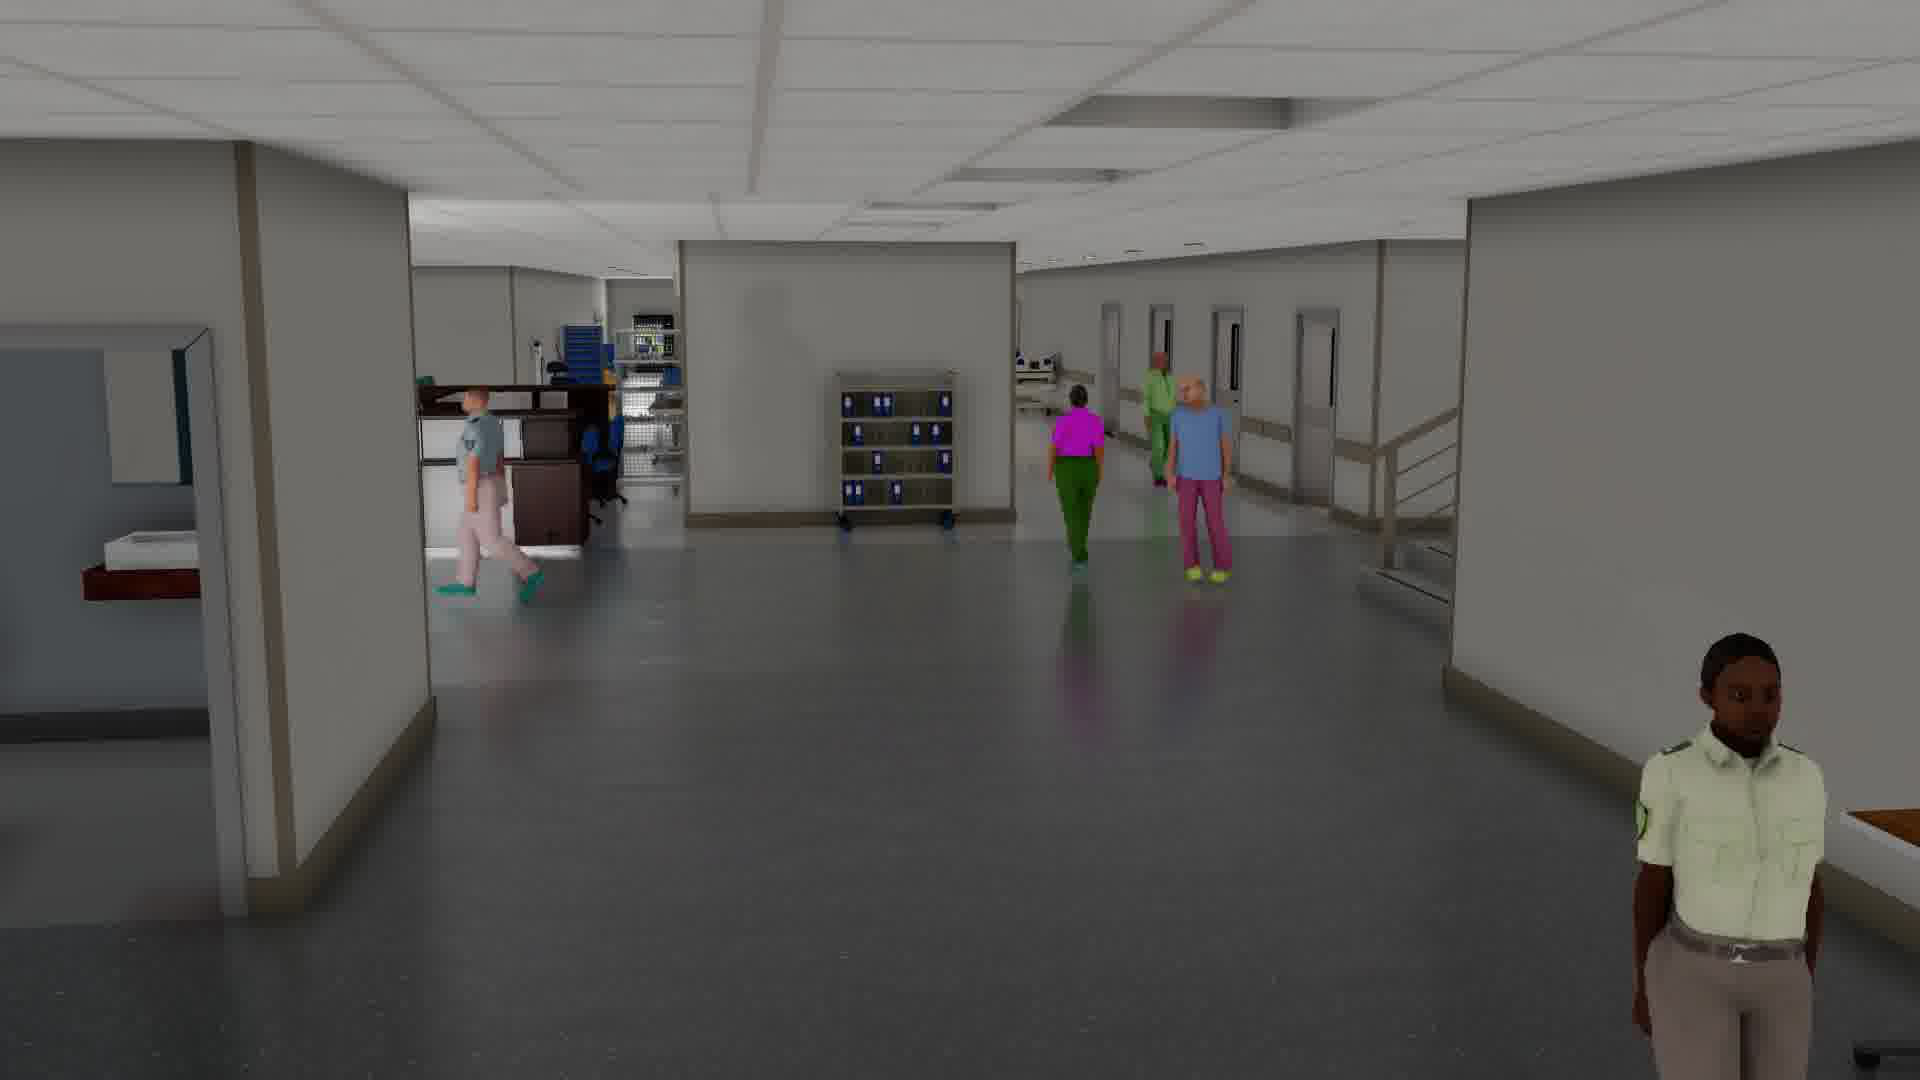

Detections:


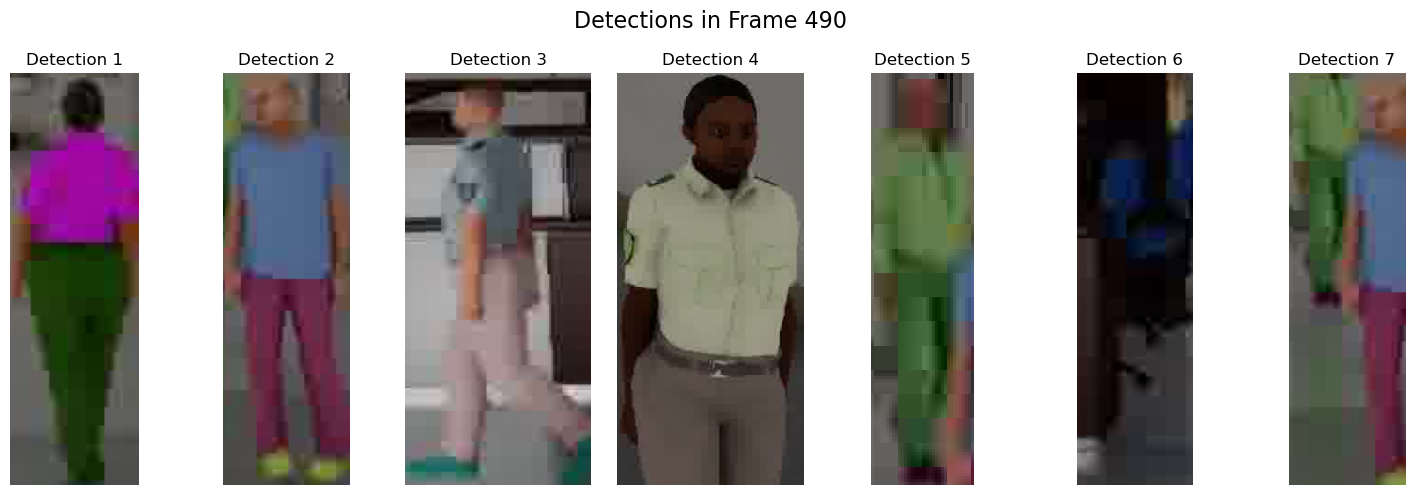

In [50]:
video_frame_detect(75, 490)

In [16]:
def similarity(vid_num, frame_num, prev_frame, next_id):
    # Get the detections and embeddings of the current frame
    curr_frame = video_frame_detect(vid_num, frame_num)

    # Calculate the cost matrix using cosine distance between embeddings
    cost_matrix = [[distance.cosine(curr_emb, prev_emb) for _, prev_emb in prev_frame] for _, curr_emb in curr_frame]

    # If there are no detections in the current frame
    if not cost_matrix:
        # Create pairs with new detections and increment the next_id
        pairs = [(None, (Object_Detection(det, next_id), emb)) for det, emb in curr_frame]
        next_id += len(curr_frame)
        return pairs, next_id

    # Apply the Hungarian algorithm to find the optimal pairings
    m = Munkres()
    coords = m.compute(cost_matrix)

    # If there are no detections in the previous frame
    if not coords:
        # Create pairs with new detections and increment the next_id
        pairs = [(None, (Object_Detection(det, next_id), emb)) for det, emb in curr_frame]
        next_id += len(curr_frame)
        return pairs, next_id

    # Pair the detections from the current frame with the corresponding detections from the previous frame
    pairs = []
    for curr, prev in coords:
        if curr != prev:
            # Create a new detection pair with a new track ID and increment the next_id
            pairs.append((None, (Object_Detection(curr_frame[curr][0], next_id), curr_frame[curr][1])))
            next_id += 1
        else:
            # Use the existing detection pair from the previous frame
            pairs.append((prev_frame[prev], (Object_Detection(curr_frame[curr][0], prev_frame[prev][0][1]), prev_frame[prev][1])))

    return pairs, next_id

In [17]:
# Associate detections between current frame (detection) and
# previous frame (tracking). Return pairs of matching detection
# objects or singular new objects
def similarity(vid_num, frame_num, prev_frame, next_id):
    # Format: frame = list[tuple], tuple = (detection, embedding)
    # curr_frame has detection tuple, prev_frame has detection
    # object!!!
    curr_frame = video_frame_detect(vid_num, frame_num)
    
    # Calculate cost matrix, rows are current frame detections, 
    # columns are previous frame detections
    cost_matrix = []
    for i in curr_frame:
        curr_frame_costs = []
        for j in prev_frame:
            curr_frame_costs.append(distance.cosine(i[1], j[1]))
        cost_matrix.append(curr_frame_costs)
    
    # No detections in current frame
    if not cost_matrix:
        return [], next_id

    # Hungarian method for least cost
    m = Munkres()
    coords = m.compute(cost_matrix)
    
    # No detections in previous frame
    if not coords:
        pairs = []
        for det, emb in curr_frame:
            pairs.append((None, (Object_Detection(det, next_id), emb)))
            next_id += 1
        return pairs, next_id
    
    # Pair prev/curr frame detections together
    pairs = []
    i = 0
    for curr, prev in coords:   
        # If new detection, insert (None, curr_detection)
        if curr != i:
            pairs.append((None, (Object_Detection(curr_frame[i][0], next_id), curr_frame[i][1])))
            next_id += 1
        else:
            pairs.append((prev_frame[prev], (Object_Detection(curr_frame[curr][0], prev_frame[prev][0][1]), prev_frame[prev][1])))
        i += 1
    return pairs, next_id

In [19]:
def show_pairs(pairs):
    num_pairs = len(pairs)
    fig, axs = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))
    
    for i, (prev, curr) in enumerate(pairs):
        if prev is None:
            # If it's a new detection, display the current detection
            axs[i, 0].axis('off')
            axs[i, 0].imshow(plot_img_det(curr[0]))
            axs[i, 0].set_title("New Detection")
            axs[i, 1].axis('off')  # Remove empty plot on the right
        else:
            # If it's a detection pair, display the previous and current detections side by side
            axs[i, 0].axis('off')
            axs[i, 0].imshow(plot_img_det(prev[0]))
            axs[i, 0].set_title("Previous Detection")
            axs[i, 1].axis('off')
            axs[i, 1].imshow(plot_img_det(curr[0]))
            axs[i, 1].set_title("Current Detection")
    
    # Add overall title to the figure
    fig.suptitle("Detection Pairs")
    
    plt.tight_layout()
    plt.show()



Original Frame:


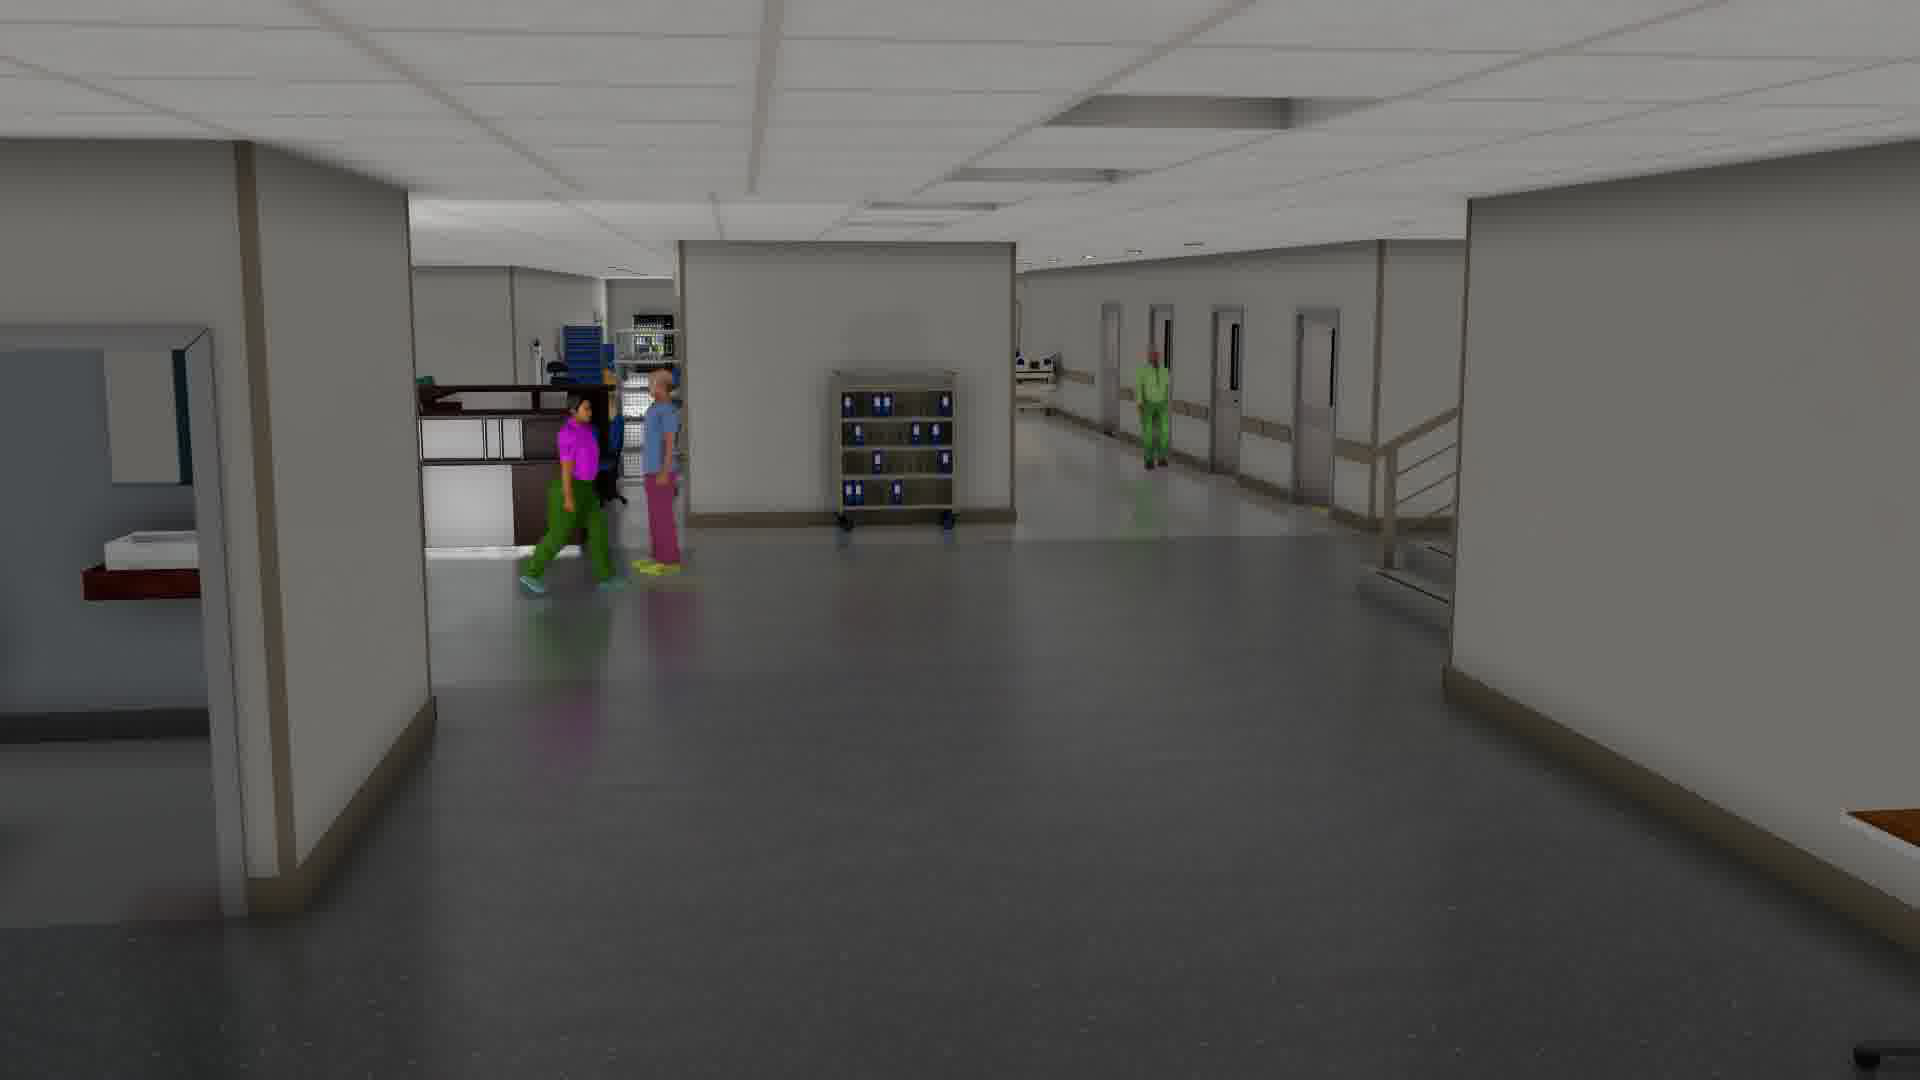

Detections:


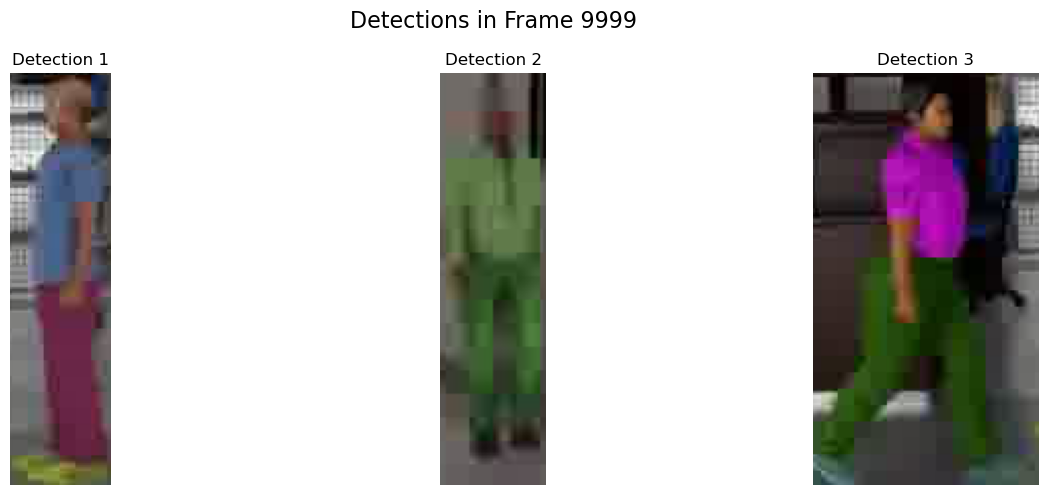

Original Frame:


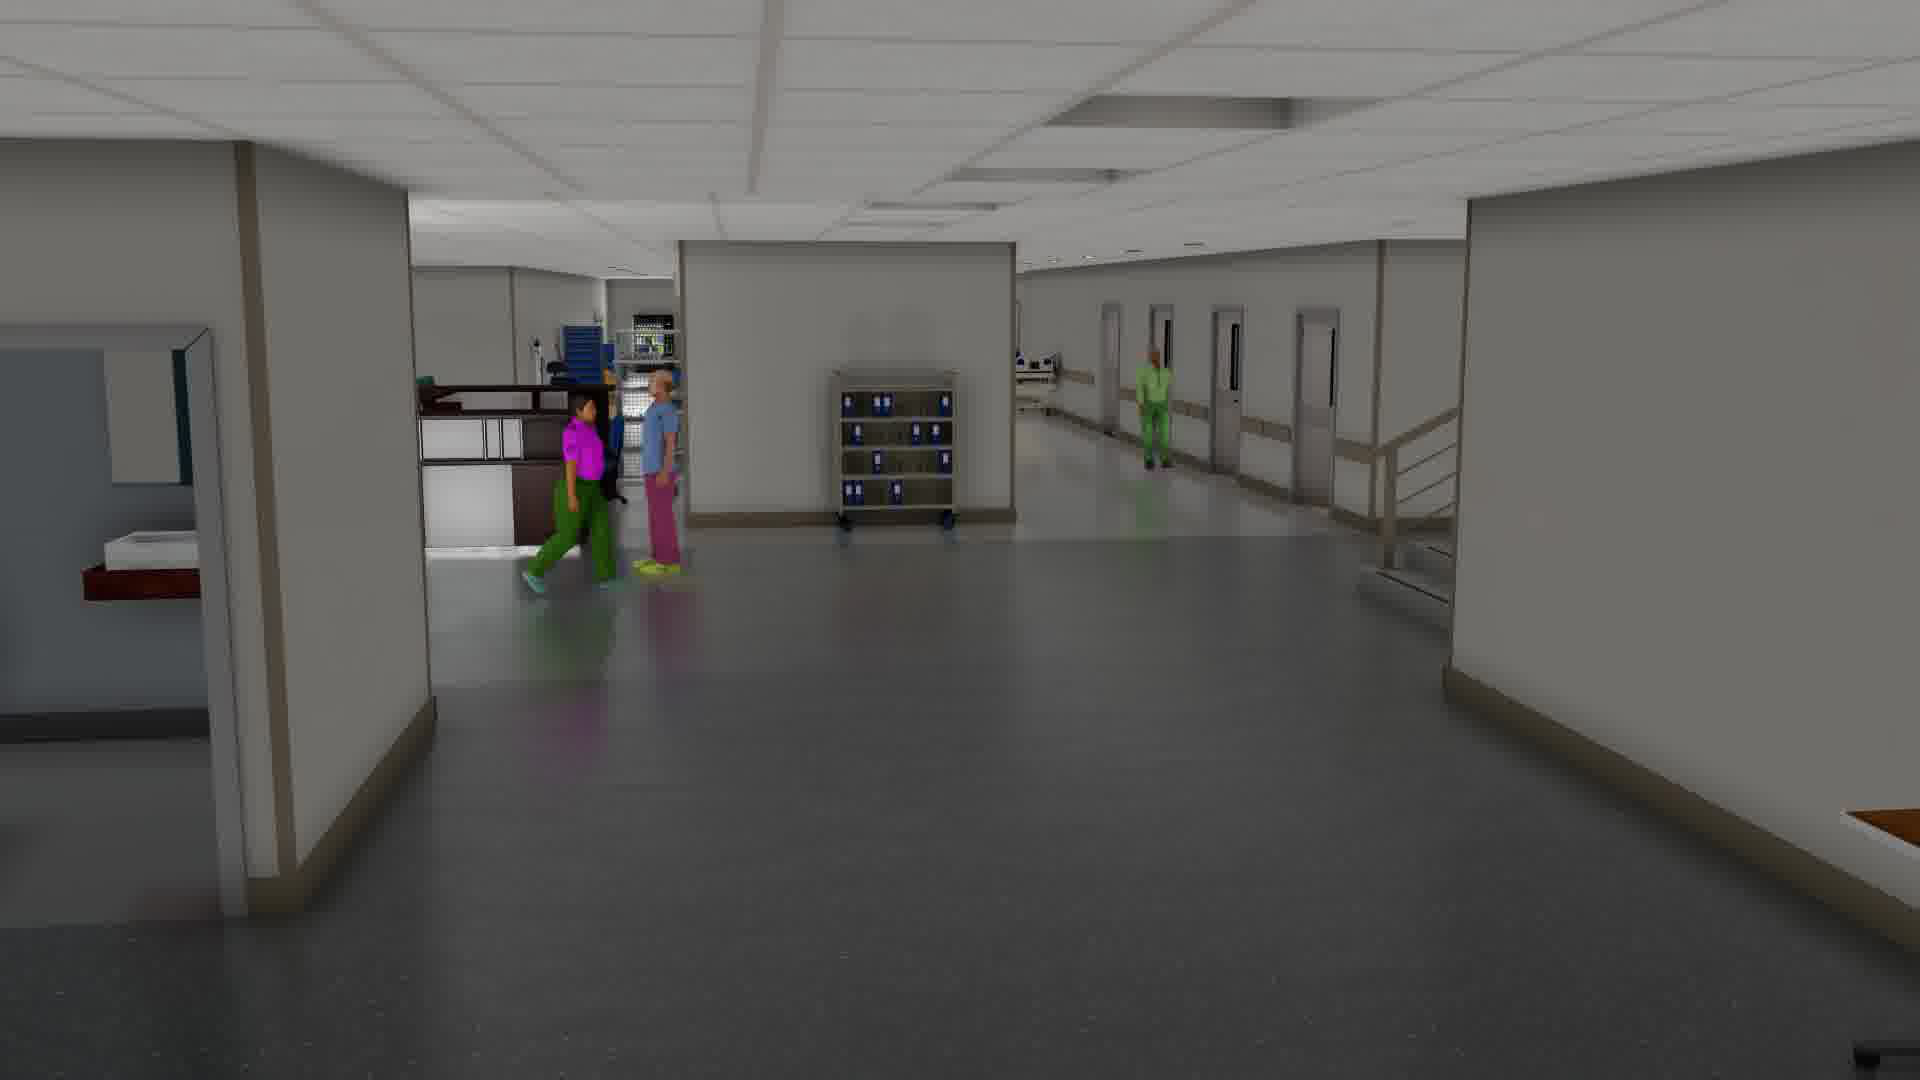

Detections:


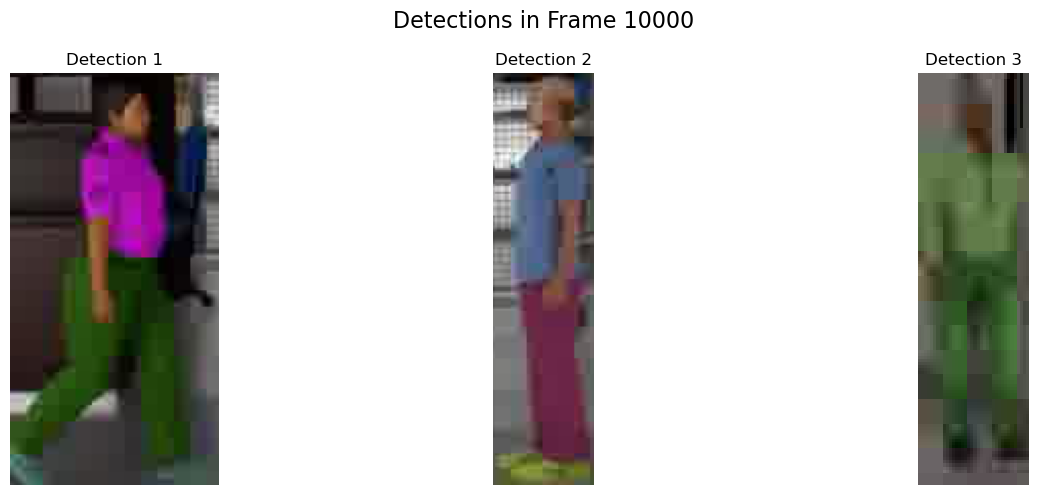

TypeError: 'NoneType' object is not iterable

In [20]:

frame = 10000
pairs, _ = similarity(75, frame, video_frame_detect(75, frame-1),0)
show_pairs(pairs)

In [ ]:
def track(vid_num):
    # Track each person and keep detections in a list under that ID
    # Key: ID number
    # Value: list[detections]
    IDs = {}
    next_id = 0
    prev_frame = []
    for frame in range(0, 18010):
        pairs, next_id = similarity(vid_num, frame, prev_frame, next_id)
        for _, curr_det_emb in pairs:
            curr_det = curr_det_emb[0]
            if not curr_det[1] in IDs:
                IDs[curr_det[1]] = []
            IDs[curr_det[1]].append(curr_det)
        prev_frame = [curr for _, curr in pairs]
        
    return IDs

Original Frame:


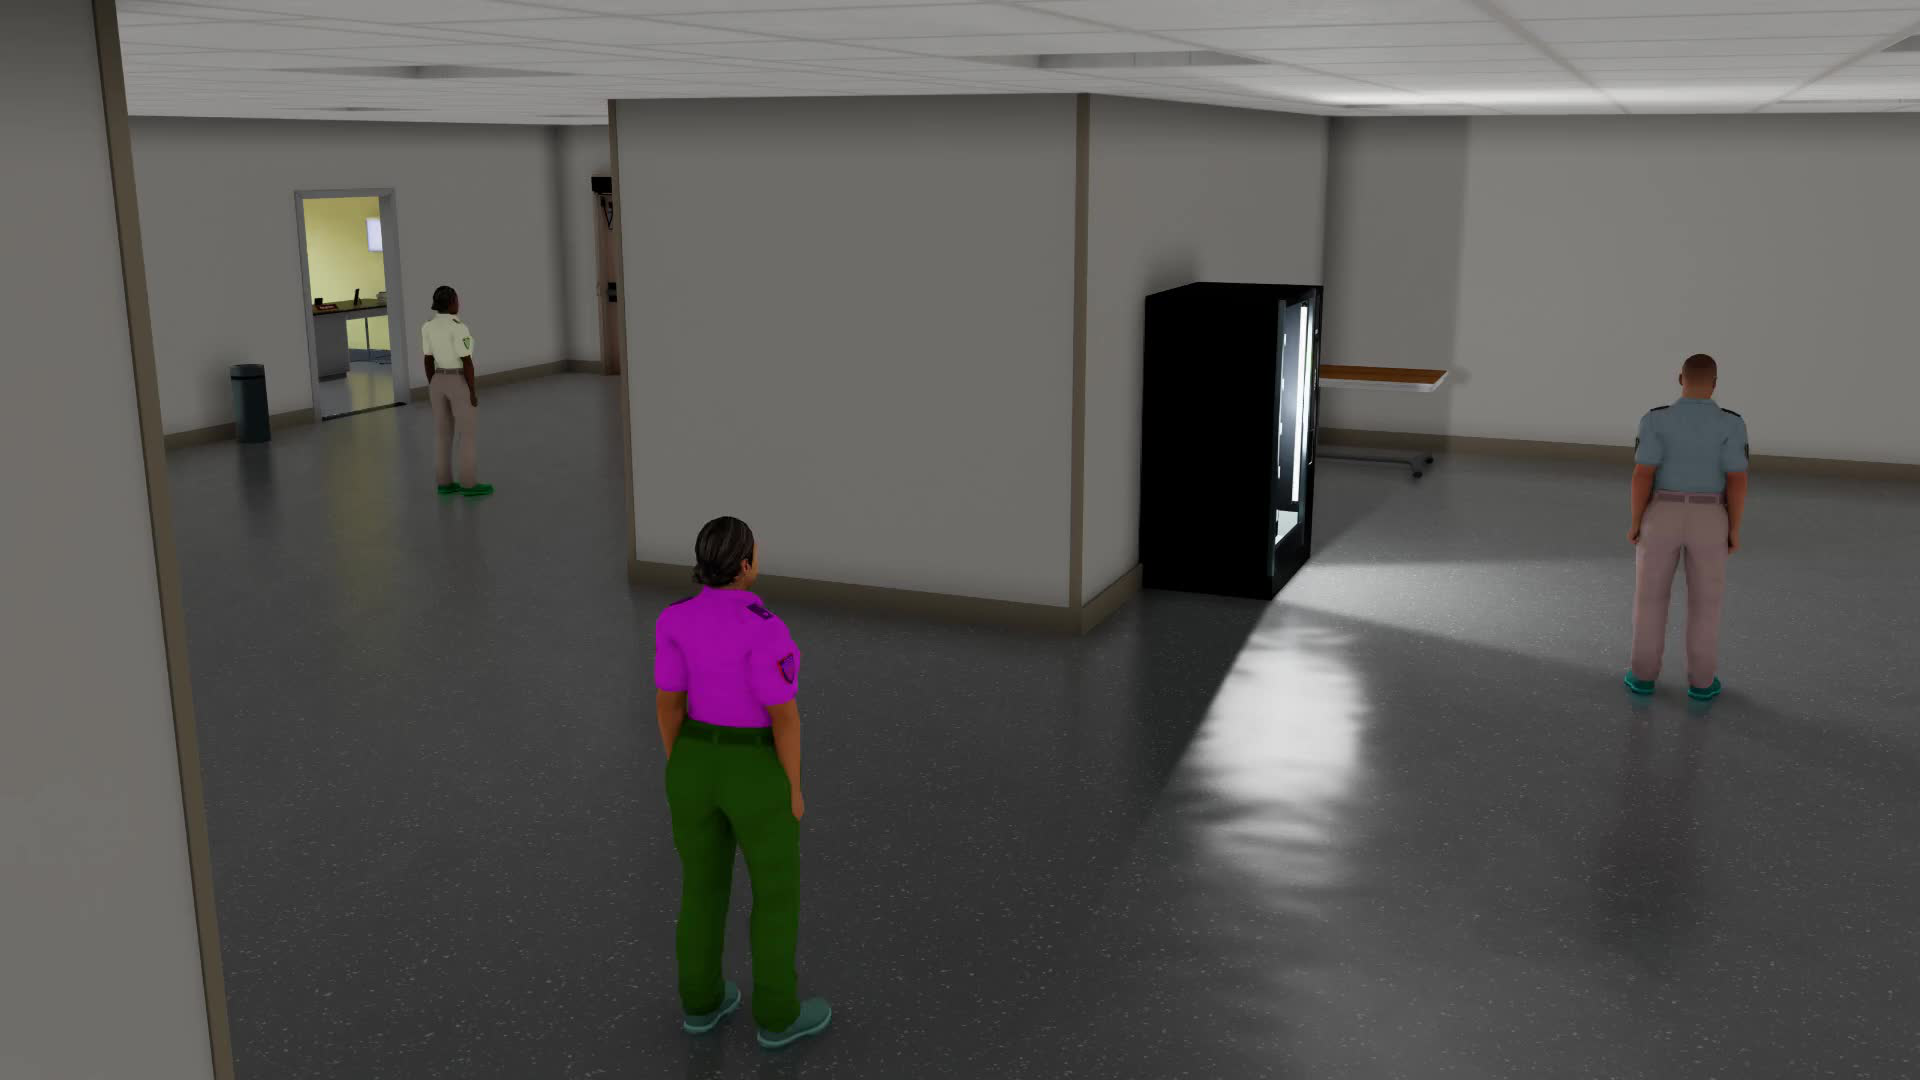

Detections:


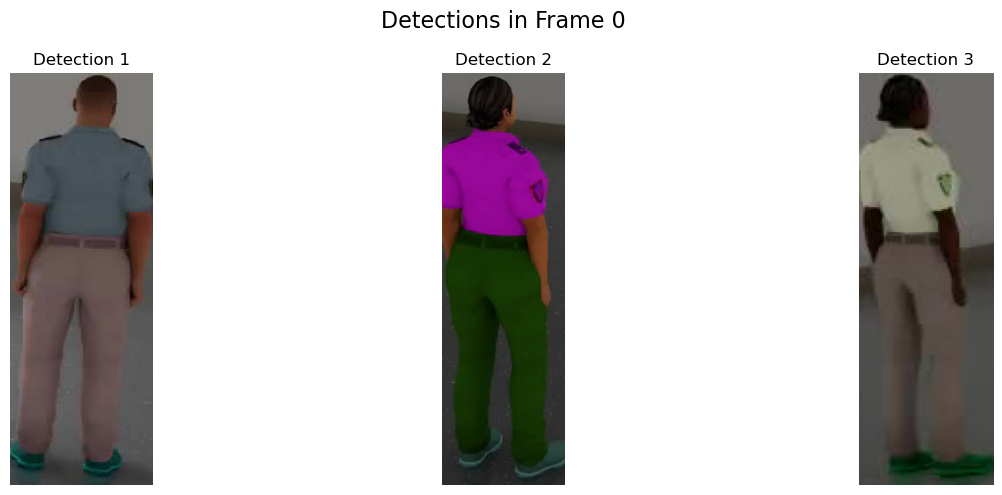

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_457171/3343248767.py", line 1, in <module>
    tracking_output_74 = track(74)
                         ^^^^^^^^^
  File "/tmp/ipykernel_457171/2799749623.py", line 9, in track
    pairs, next_id = similarity(vid_num, frame, prev_frame, next_id)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_457171/1978996221.py", line 13, in similarity
    for i in curr_frame:
TypeError: 'NoneType' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^

In [ ]:
tracking_output = track(74)

In [ ]:
def show_track_id(track_id_outputs, track_id):
    # Get the list of detections for the specified track_id
    outputs = track_id_outputs[track_id]
    
    # Calculate the number of rows and columns for subplots based on the number of detections
    num_detections = len(outputs)
    num_rows = (num_detections + 9) // 10  # Round up to the nearest multiple of 10
    num_cols = min(num_detections, 10)  # Maximum 10 columns
    
    # Create subplots for visualization
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    
    # Set the title of the figure
    fig.suptitle(f"Track ID: {track_id}")
    
    # Iterate through the detections and plot them on the subplots
    for ind, det in enumerate(outputs):
        row = ind // num_cols
        col = ind % num_cols
        
        ax = axs[row, col] if num_rows > 1 else axs[col]  # Handle single row case
        
        ax.axis('off')
        ax.set_title(f"Detection {ind+1}")
        
        img = Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[1])).crop((det[3], det[4], det[5], det[6]))
        ax.imshow(img)
    
    # Remove empty subplots
    if num_detections < num_rows * num_cols:
        empty_plots = axs.flatten()[num_detections:]
        for ax in empty_plots:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()



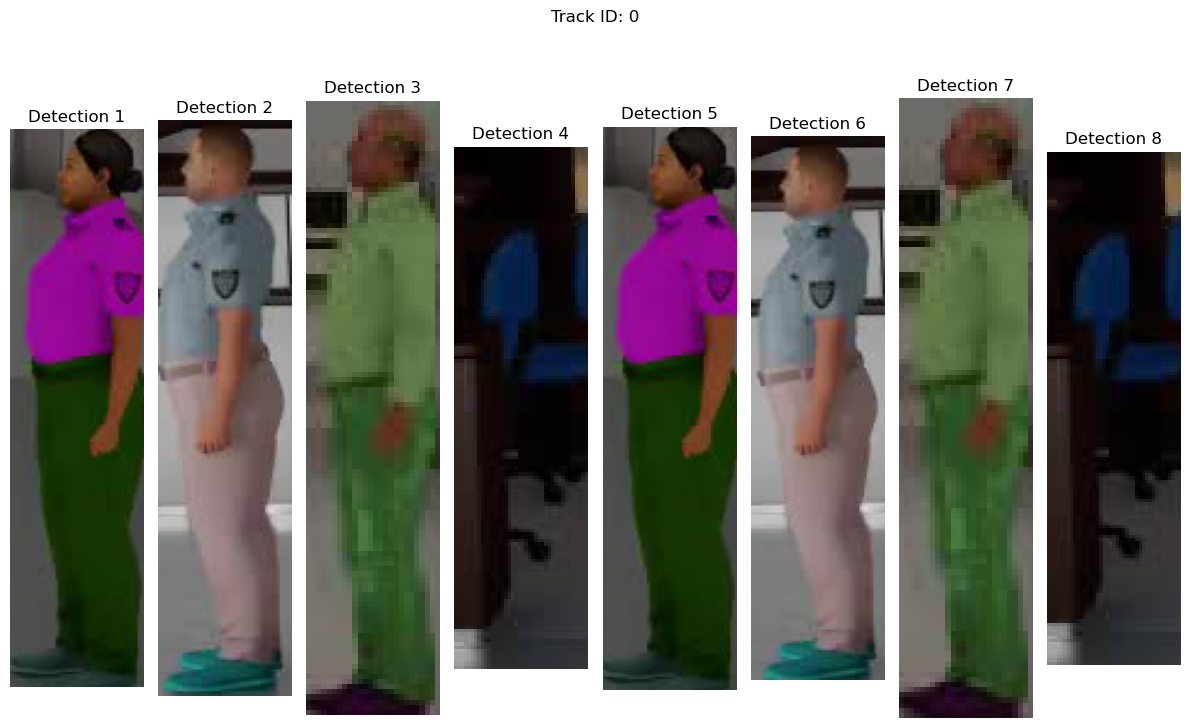

In [ ]:
show_track_id(tracking_output,0)

In [ ]:
#Last Part

In [1]:
import numpy as np
from PIL import Image
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from munkres import Munkres
from sklearn.cluster import KMeans

In [2]:
#processing the output file

# This is the baseline code for merging the fragment tracklet using clustering based on appearance


class postprocess:
    def __init__(self,number_of_people,cluster_method):
        self.n = number_of_people
        if cluster_method == 'kmeans':
            self.cluster_method = KMeans(n_clusters=self.n, random_state=0)
        else:
            raise NotImplementedError
    
    def run(self,features):

        print('Start Clustering')

        self.cluster_method.fit(features)

        print('Finish Clustering')

        return self.cluster_method.labels_

In [3]:
#IOU based clustering

# calculate the overlap ratio of two bounding boxes
def calculate_iou(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    area_bbox1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area_bbox2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    iou = intersection_area / float(area_bbox1 + area_bbox2 - intersection_area)
    # Calculate additional similarity metrics
    center1_x = (x1_1 + x2_1) / 2
    center1_y = (y1_1 + y2_1) / 2
    center2_x = (x1_2 + x2_2) / 2
    center2_y = (y1_2 + y2_2) / 2
    distance = np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)

    # Combine the similarity metrics (IoU and distance) into a single similarity score
    similarity_score = 0.7 * iou + 0.3 * (1 / (1 + distance))  # Example combination

    return similarity_score
    #return iou


# base class for tracklet
class Tracklet:
    def __init__(self, tracking_ID, box, feature, time, confidence):
        self.ID = tracking_ID
        self.boxes = [box]
        self.features = [feature]
        self.times = [time]
        self.confidences = [confidence]

        self.cur_box = box
        self.cur_feature = None
        self.alive = True

        self.final_features = None

    def update(self, box, feature, time, confidence):
        self.cur_box = box
        self.boxes.append(box)
        self.cur_feature = None
        self.features.append(feature)
        self.times.append(time)
        self.confidences.append(confidence)
        self.get_avg_features()

    def close(self):
        self.alive = False

    def get_avg_features(self):
        self.final_features = (
            sum(self.features) / len(self.features)
            if self.features
            else None
        )


# class for multi-object tracker
class tracker:
    def __init__(self):
        self.all_tracklets = []
        self.cur_tracklets = []

    def run(self, detections, features):
        for frame_id in range(0, 18010):
            if frame_id % 1000 == 0:
                print('Tracking | cur_frame {} | total frame 18010'.format(frame_id))

            inds = detections[:, 1] == frame_id
            cur_frame_detection = detections[inds]
            cur_frame_features = features[inds]

            # no tracklets in the first frame
            if len(self.cur_tracklets) == 0:
                for idx in range(len(cur_frame_detection)):
                    new_tracklet = Tracklet(
                        len(self.all_tracklets) + 1,
                        cur_frame_detection[idx][3:7],
                        cur_frame_features[idx],
                        frame_id,
                        cur_frame_detection[idx][2]  # confidence value
                    )
                    self.cur_tracklets.append(new_tracklet)
                    self.all_tracklets.append(new_tracklet)

            else:
                cost_matrix = np.zeros((len(self.cur_tracklets), len(cur_frame_detection)))

                for i in range(len(self.cur_tracklets)):
                    for j in range(len(cur_frame_detection)):
                        cost_matrix[i][j] = 1 - calculate_iou(
                            self.cur_tracklets[i].cur_box, cur_frame_detection[j][3:7]
                        )

                row_inds, col_inds = linear_sum_assignment(cost_matrix)

                matches = min(len(row_inds), len(col_inds))

                for idx in range(matches):
                    row, col = row_inds[idx], col_inds[idx]
                    if cost_matrix[row, col] == 1:
                        self.cur_tracklets[row].close()
                        new_tracklet = Tracklet(
                            len(self.all_tracklets) + 1,
                            cur_frame_detection[col][3:7],
                            cur_frame_features[col],
                            frame_id,
                            cur_frame_detection[col][2]  # confidence value
                        )
                        self.cur_tracklets.append(new_tracklet)
                        self.all_tracklets.append(new_tracklet)
                    else:
                        self.cur_tracklets[row].update(
                            cur_frame_detection[col][3:7],
                            cur_frame_features[col],
                            frame_id,
                            cur_frame_detection[col][2],  # confidence value
                        )

                # initiate unmatched detections as new tracklets
                for idx, det in enumerate(cur_frame_detection):
                    if idx not in col_inds:
                        new_tracklet = Tracklet(
                            len(self.all_tracklets) + 1,
                            det[3:7],
                            cur_frame_features[idx],
                            frame_id,
                            det[2],  # confidence value
                        )
                        self.cur_tracklets.append(new_tracklet)
                        self.all_tracklets.append(new_tracklet)

            self.cur_tracklets = [trk for trk in self.cur_tracklets if trk.alive]

        final_tracklets = self.all_tracklets

        for trk_id in range(len(final_tracklets)):
            final_tracklets[trk_id].get_avg_features()

        return final_tracklets


In [11]:

if __name__ == "__main__":

    #camera = 74 # validation set
    camera = 75  # test set

    # The number of people in the dataset is 5. Bonus points for method that does not require this line of hard coding
    number_of_people = 5


    result_path = 'baseline_result.txt'

    # Load the data
    detection = np.loadtxt('./detection.txt', delimiter=',', dtype=None)
    embedding = np.load('./embedding.npy', allow_pickle=True)
    inds = detection[:, 0] == camera
    test_detection = detection[inds]
    test_embedding = embedding[inds]
    sort_inds = test_detection[:, 1].argsort()
    test_detection = test_detection[sort_inds]
    test_embedding = test_embedding[sort_inds]

    # Filter out low-confidence detections

    confidence_threshold = 0.5
    confidence_mask = test_detection[:, 7] >= confidence_threshold
    test_detection = test_detection[confidence_mask]
    test_embedding = test_embedding[confidence_mask]


    mot = tracker()
    postprocessing = postprocess(number_of_people, 'kmeans')

    # Run the IoU tracking
    tracklets = mot.run(test_detection, test_embedding)

    features = np.array([trk.final_features for trk in tracklets])

    # Run the Post Processing to merge the tracklets
    labels = postprocessing.run(features)  # The label represents the final tracking ID, it starts from 0. We will make it start from 1 later.

    tracking_result = []

    print('Writing Result ...')

    for i, trk in enumerate(tracklets):
        final_tracking_id = labels[i] + 1  # make it start with 1
        for idx in range(len(trk.boxes)):
            frame = trk.times[idx]
            x1, y1, x2, y2 = trk.boxes[idx]
            x, y, w, h = x1, y1, x2 - x1, y2 - y1

            result = '{},{},{},{},{},{},{},-1,-1 \n'.format(camera, final_tracking_id, frame, x, y, w, h)

            tracking_result.append(result)

    print('Save tracking results at {}'.format(result_path))

    with open(result_path, 'w') as f:
        f.writelines(tracking_result)


Tracking | cur_frame 0 | total frame 18010
Tracking | cur_frame 1000 | total frame 18010
Tracking | cur_frame 2000 | total frame 18010
Tracking | cur_frame 3000 | total frame 18010
Tracking | cur_frame 4000 | total frame 18010
Tracking | cur_frame 5000 | total frame 18010
Tracking | cur_frame 6000 | total frame 18010
Tracking | cur_frame 7000 | total frame 18010
Tracking | cur_frame 8000 | total frame 18010
Tracking | cur_frame 9000 | total frame 18010
Tracking | cur_frame 10000 | total frame 18010
Tracking | cur_frame 11000 | total frame 18010
Tracking | cur_frame 12000 | total frame 18010
Tracking | cur_frame 13000 | total frame 18010
Tracking | cur_frame 14000 | total frame 18010
Tracking | cur_frame 15000 | total frame 18010
Tracking | cur_frame 16000 | total frame 18010
Tracking | cur_frame 17000 | total frame 18010


/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4bbb43fec0>
Traceback (most recent call last):
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
  

Tracking | cur_frame 18000 | total frame 18010
Start Clustering


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4bbb43ff60>
Traceback (most recent call last):
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/andrew/miniconda3/envs/cuda/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
A

Finish Clustering
Writing Result ...
Save tracking results at baseline_result.txt


In [12]:
!python ./visualization.py ./baseline_result.txt --dstype=test

Saving visualization result at test_visualization
processing frame:  0
processing frame:  100
processing frame:  200
processing frame:  300
processing frame:  400
processing frame:  500
processing frame:  600
processing frame:  700
processing frame:  800
processing frame:  900
processing frame:  1000


In [13]:
from pathlib import Path
import imageio

image_path = Path('./test_visualization')
images = list(image_path.glob('*.jpg'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    


/tmp/ipykernel_9689/2908565192.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_list.append(imageio.imread(file_name))


In [14]:
imageio.mimwrite('./checkcheck2.gif', image_list, fps=3)

In [ ]:
!python ./evaluation/eval.py ./baseline_result.txt ./evaluation/gt/74.txt

          IDF1   IDP   IDR    idtp   idfp   idfn  MOTA  MOTP  Rcll  Prcn  IDs MT PT ML
MultiCam 86.80 81.41 86.67 27262.0 6226.0 4194.0 85.04 10.67 95.03 95.32 1674  3  1  1
